# training data
Masking by training data shapefile example.

In [1]:
from eo_stack import *
# First change name[25:33]
s2 = S2TempStack('/home/azalazar/data/Saldana/pre_orig/pre/', '/home/azalazar/data/Saldana/pre/stack/')
s2_xar = s2.getXarray()
s2_xds = s2.getXDataset()

S2 object initialized from /home/azalazar/data/Saldana/pre_orig/pre/


/home/azalazar/anaconda2/envs/read-explore/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


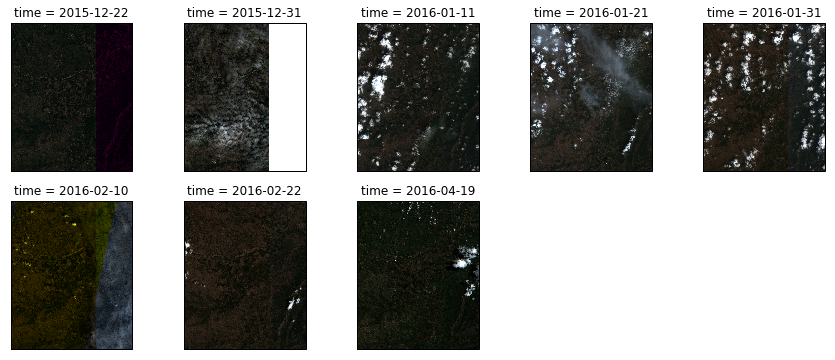

In [3]:
from eotemparray import *
s2_xar.eotemp.plot_RGB()

### create mask from shapefile
the general approach is reading and rasterizing shapefiles using rasterio (need to reproject to eo images crs). The resulting object can the be read using xarray rasterio method, which can be used to mask xarray objects.

In [2]:
import rasterio, dask
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from affine import Affine
from rasterio import features

In [3]:
reference_file = "/home/azalazar/data/Saldana/pre/stack/NDVI_S2_20160222_.tif"
rasterized_file = '/home/azalazar/data/training_data/test_raster.tif'

In [8]:
out_dir = '/home/azalazar/data/training_data/'

rst = rasterio.open(reference_file)
meta = rst.meta.copy()
meta.update(compress='lzw', dtype=rasterio.float64)

dates = []

lotes = gpd.read_file('/home/azalazar/data/training_data/saldana.shp').to_crs({'init': 'epsg:32618'})

for column in lotes:
    
    if lotes[column].name[0] == 'X':
        
        date = lotes[column].name[1:]
        out_file = out_dir+date+'.tif'
        
        dates.append(date)
        
        #with rasterio.open(out_file, 'w', **meta) as out:
        #    out_arr = out.read(1)
        #    shapes = ((geom,value) for geom, value in zip(lotes.geometry, lotes[column].astype('float64')))
        #    burned = rasterio.features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        #    out.write_band(1, burned.astype(rasterio.float64))

In [13]:
dates = ['20151222', '20151231', '20160111', '20160121']
dates2 = ['2015-12-22', '2015-12-31', '2016-01-11', '2016-01-21']

In [14]:
def getXarray(raster_dir, dates):
    """Returns an xarray object from all dates in a given band"""
    time = xr.Variable('time', pd.DatetimeIndex([pd.Timestamp(f) for f in dates]))
    arlist = [xr.open_rasterio(f) for f in list(map(lambda x: raster_dir+x+'.tif', dates))]
    da = xr.concat(arlist, dim=time)
    return da

rice_plots_ph = getXarray(out_dir, dates).isel(band=0).drop('band')

In [34]:
app = []
for date in dates2:
    app.append(s2_xds.sel(time=date))
sat_data = xr.concat(app, 'time').transpose('time','x','y')

In [35]:
class_data = rice_plots_ph.transpose('time','x','y')

In [36]:
sat_data['phc'] = (('time', 'x', 'y'), class_data)

In [64]:
## Store data in disk

sat_data.to_netcdf('/home/azalazar/data/training_data/s2phc.nc')

In [65]:
## Read from disk

sat_data_again = xr.open_mfdataset('/home/azalazar/data/training_data/s2phc.nc')
sat_data_again

<xarray.Dataset>
Dimensions:   (time: 4, x: 2979, y: 3631)
Coordinates:
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y         (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time      (time) datetime64[ns] 2015-12-22 2015-12-31 2016-01-11 2016-01-21
    mask      (time, x, y) bool dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
Data variables:
    blue      (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    swir1     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    swir2     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    qa_class  (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    qa_cloud  (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
    green     (time, x, y) float64 dask.array<shape=(4, 2979, 3631), chunksize=(4, 2979, 3631)>
   

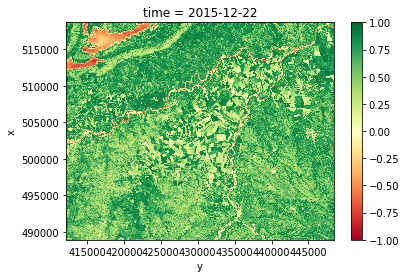

In [71]:
sat_data_again['NDVI'].sel(time='2015-12-22').where(sat_data_again.mask.sel(time='2015-12-22')).plot(vmin=-1., vmax=1., cmap='RdYlGn')

In [41]:
pddf = sat_data.to_dataframe()

In [60]:
valid = pddf.loc[pddf['phc'] > 0]
valid2 = valid.loc[valid['mask'] == True]

In [61]:
valid2

blue   swir1   swir2  qa_class  qa_cloud  \
time       x        y                                                      
2015-12-22 499455.0 425215.0   312.0  1127.0   529.0       4.0       0.0   
                    425205.0   297.0  1127.0   529.0       4.0       0.0   
                    425195.0   326.0  1177.0   578.0       4.0       0.0   
           499465.0 425245.0   342.0  1199.0   605.0       4.0       0.0   
                    425235.0   321.0  1256.0   622.0       4.0       0.0   
                    425225.0   347.0  1256.0   622.0       4.0       0.0   
                    425215.0   340.0  1243.0   610.0       4.0       0.0   
                    425205.0   313.0  1243.0   610.0       4.0       0.0   
                    425195.0   328.0  1210.0   587.0       4.0       0.0   
                    425185.0   315.0  1210.0   587.0       4.0       0.0   
           499475.0 425265.0   326.0  1222.0   616.0       4.0       0.0   
                    425255.0   334.0  1199.0   605.0       4.0       0.0   
                    425245.0   332.0  1199.0   605.0       4.0       0.0   
                    425235.0   331.0  1256.0   622.0       4.0       0.0   
                    425225.0   332.0  1256.0   622.0       4.0       0.0   
                    425215.0   305.0  1243.0   610.0       4.0       0.0   
                    425205.0   289.0  1243.0   610.0       4.0       0.0   
                    425195.0   307.0  1210.0   587.0       4.0       0.0   
                    425185.0   297.0  1210.0   587.0       4.0       0.0   
           499485.0 425285.0   311.0  1173.0   523.0       4.0       0.0   
                    425275.0   305.0  1141.0   528.0       4.0       0.0   
                    425265.0   310.0  1141.0   528.0       4.0       0.0   
                    425255.0   316.0  1251.0   594.0       4.0       0.0   
                    425245.0   321.0  1251.0   594.0       4.0       0.0   
                    425235.0   331.0  1424.0   661.0       4.0       0.0   
                    425225.0   337.0  1424.0   661.0       4.0       0.0   
                    425215.0   337.0  1359.0   661.0       4.0       0.0   
                    425205.0   299.0  1359.0   661.0       4.0       0.0   
                    425195.0   315.0  1275.0   610.0       4.0       0.0   
                    425185.0   307.0  1275.0   610.0       4.0       0.0   
...                              ...     ...     ...       ...       ...   
2016-01-21 503815.0 433835.0  1028.0  2076.0  1222.0      10.0       1.0   
                    433825.0  1054.0  2076.0  1222.0      10.0       1.0   
                    433775.0  1003.0  1996.0  1158.0      10.0       2.0   
                    433765.0  1054.0  1996.0  1158.0      10.0       2.0   
                    433755.0  1078.0  1963.0  1153.0      10.0       6.0   
                    433745.0  1019.0  1963.0  1153.0      10.0       6.0   
                    433735.0  1053.0  1962.0  1144.0      10.0       5.0   
                    433725.0  1048.0  1962.0  1144.0      10.0       5.0   
           503825.0 433775.0  1006.0  1981.0  1163.0      10.0       2.0   
                    433765.0  1017.0  1981.0  1163.0      10.0       2.0   
                    433755.0   998.0  1961.0  1158.0      10.0       3.0   
                    433745.0  1011.0  1961.0  1158.0      10.0       3.0   
                    433735.0  1059.0  1966.0  1153.0      10.0       2.0   
                    433725.0  1029.0  1966.0  1153.0      10.0       2.0   
           503835.0 433775.0   969.0  1981.0  1163.0      10.0       2.0   
                    433765.0  1017.0  1981.0  1163.0      10.0       2.0   
                    433755.0  1036.0  1961.0  1158.0      10.0       3.0   
                    433745.0  1011.0  1961.0  1158.0      10.0       3.0   
                    433735.0  1041.0  1966.0  1153.0      10.0       2.0   
                    433725.0  1008.0  1966.0  1153.0      10.0       2.0   
    

In [62]:
backxa = xr.Dataset.from_dataframe(valid2)
backxa

<xarray.Dataset>
Dimensions:   (time: 4, x: 2979, y: 3631)
Coordinates:
  * time      (time) datetime64[ns] 2015-12-22 2015-12-31 2016-01-11 2016-01-21
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y         (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
Data variables:
    blue      (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir1     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    swir2     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    qa_class  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    qa_cloud  (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    green     (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    nir       (time, x, y) float64 nan nan nan nan nan nan nan nan nan nan ...
    NDVI      (time, x, y) float32 nan nan nan nan nan nan nan nan nan nan ...
    LSWI      (time, x, y) float32 nan n

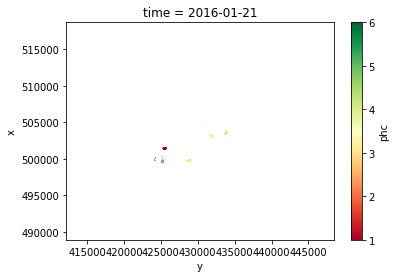

In [63]:
backxa['phc'].sel(time='2016-01-21').plot(vmin=1., vmax=6., cmap='RdYlGn')

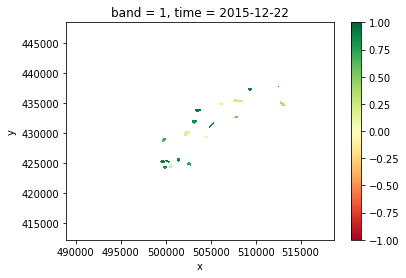

In [101]:
s2_xds['NDVI'].sel(time='20151222').where(rice_plots_ph.sel(time='20151222')!=0).plot(vmin=-1., vmax=1., cmap='RdYlGn')